# AuthAi: Model Comparison Notebook

This notebook reproduces the analysis and comparison of models for AuthAi (behavioral biometrics).

**Important:** Some cells (LSTM/Transformer/Autoencoder) require TensorFlow. This runtime lacked TensorFlow, so those cells are included but not executed here. Run the notebook on Colab or a TF-enabled environment to execute sequence models and autoencoder.

Files produced by this run (if run fully):
- `models/user_behavior_dataset.csv` (input)
- `models/model_comparison_results.csv` (results summary)
- saved model artifacts in `models/` (if trained)


In [ ]:
# Cell 1: basic imports and load data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

np.random.seed(42)
DATA_PATH = '/content/user_behavior_dataset.csv'
df = pd.read_csv(DATA_PATH)
print('Loaded dataset with shape:', df.shape)

df.head()


Loaded dataset with shape: (10000, 8)


,user_id,avg_mouse_speed,avg_typing_speed,tab_switch_rate,mouse_click_rate,keyboard_error_rate,active_window_duration,is_improper_user
0,1,899.342831,216.075263,5.696572,5.097140,1.528142,122.946184,0
1,2,772.347140,234.725027,5.566647,9.725072,3.012702,118.076753,1
2,3,929.537708,220.130947,3.126960,12.064858,1.801813,148.553723,1
3,4,1104.605971,255.520902,6.159168,15.748345,2.090569,165.984934,0
4,5,753.169325,309.858927,2.019835,20.120812,2.717391,140.605408,0


In [ ]:
# Cell 2: train/test split and scaling
features = ['avg_mouse_speed','avg_typing_speed','tab_switch_rate','mouse_click_rate','keyboard_error_rate','active_window_duration']
X = df[features]
y = df['is_improper_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
print('Train/test sizes:', X_train_s.shape, X_test_s.shape)


Train/test sizes: (8000, 6) (2000, 6)


In [ ]:
# Cell 3: RandomForest baseline
import os
rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
rf_pred = rf.predict(X_test_s)
rf_proba = rf.predict_proba(X_test_s)[:,1]
print('RF accuracy:', accuracy_score(y_test, rf_pred))
print('RF ROC AUC:', roc_auc_score(y_test, rf_proba))
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/rf_model.joblib")


RF accuracy: 0.847
RF ROC AUC: 0.5265759196240479


['models/rf_model.joblib']

In [ ]:
# Cell 4: XGBoost (try import, fallback to GradientBoosting)
import os
os.makedirs("models", exist_ok=True)

try:
    import xgboost as xgb
    xgb_clf = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    xgb_clf.fit(X_train_s, y_train)
    xgb_pred = xgb_clf.predict(X_test_s)
    xgb_proba = xgb_clf.predict_proba(X_test_s)[:,1]
    print('XGBoost accuracy:', accuracy_score(y_test, xgb_pred))
    print('XGBoost ROC AUC:', roc_auc_score(y_test, xgb_proba))
    joblib.dump(xgb_clf, "models/xgb_model.joblib")

except Exception as e:
    from sklearn.ensemble import GradientBoostingClassifier
    xgb_clf = GradientBoostingClassifier(random_state=42)
    xgb_clf.fit(X_train_s, y_train)
    xgb_pred = xgb_clf.predict(X_test_s)
    xgb_proba = xgb_clf.predict_proba(X_test_s)[:,1]
    print('GradientBoosting (fallback) accuracy:', accuracy_score(y_test, xgb_pred))
    print('GradientBoosting (fallback) ROC AUC:', roc_auc_score(y_test, xgb_proba))
    joblib.dump(xgb_clf, "models/xgb_model.joblib")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:30:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost accuracy: 0.8315
XGBoost ROC AUC: 0.5036538031190437


In [ ]:
# Cell 5: IsolationForest (unsupervised anomaly detection)
import os
os.makedirs("models", exist_ok=True)

proper_mask = (y_train==0)
iso = IsolationForest(contamination=0.15, random_state=42)
iso.fit(X_train_s[proper_mask])

iso_scores = -iso.decision_function(X_test_s)
threshold = np.percentile(-iso.decision_function(X_train_s[proper_mask]), 85)
iso_pred = (iso_scores >= threshold).astype(int)

print('IsolationForest accuracy:', accuracy_score(y_test, iso_pred))
print('IsolationForest ROC AUC:', roc_auc_score(y_test, iso_scores))

# save safely
joblib.dump(iso, "models/iso_model.joblib")



IsolationForest accuracy: 0.7505
IsolationForest ROC AUC: 0.4761383892399935


['models/iso_model.joblib']

### Autoencoder (tabular) and Sequence models (LSTM / Transformer)
The following cells require TensorFlow. Run in a TF-enabled environment (Colab / Kaggle) to execute these sections.

In [ ]:
# Cell 6: Tabular Autoencoder (requires TensorFlow)
try:
    import os
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    os.makedirs("models", exist_ok=True)

    input_dim = X_train_s.shape[1]
    ae_encoder = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
    ])
    ae_decoder = keras.Sequential([
        layers.Input(shape=(8,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(input_dim, activation='linear'),
    ])
    ae_input = layers.Input(shape=(input_dim,))
    encoded = ae_encoder(ae_input)
    decoded = ae_decoder(encoded)
    autoencoder = keras.Model(ae_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(
        X_train_s[proper_mask], X_train_s[proper_mask],
        epochs=30, batch_size=128, validation_split=0.1, verbose=1
    )

    # Reconstruction error
    recon = autoencoder.predict(X_test_s)
    mse = np.mean(np.square(recon - X_test_s), axis=1)

    train_recon = autoencoder.predict(X_train_s[proper_mask])
    train_mse = np.mean(np.square(train_recon - X_train_s[proper_mask]), axis=1)
    ae_thresh = np.percentile(train_mse, 90)

    ae_pred = (mse >= ae_thresh).astype(int)
    print('Autoencoder accuracy:', accuracy_score(y_test, ae_pred))
    print('Autoencoder ROC AUC:', roc_auc_score(y_test, mse))

    # save safely
    autoencoder.save("models/ae_model.keras")

except Exception as e:
    print('TensorFlow not available in this runtime. Install TensorFlow to run Autoencoder and sequence models.')


Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9990 - val_loss: 0.8048
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8140 - val_loss: 0.6364
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6487 - val_loss: 0.5008
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4850 - val_loss: 0.3317
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3085 - val_loss: 0.1821
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1682 - val_loss: 0.0802
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0766 - val_loss: 0.0495
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0505 - val_loss: 0.0379
Epoch 9/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0391 - val_loss: 0.0299
Epoch 10/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0305 - val_loss: 0.0248
Epoch 11/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - val_loss: 0.0207
Epoch 12/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - val_lo

In [ ]:
# Cell 7: Synthesize sequences from aggregates (demo only)
# Replace with real per-event logs when available

import os
os.makedirs("models", exist_ok=True)

seq_len = 50
n_features_seq = len(features)

def make_sequences_from_aggregates(df, seq_len=seq_len, noise_scale=0.05):
    seqs = np.zeros((len(df), seq_len, n_features_seq))
    for i, row in df[features].iterrows():
        base = row.values.astype(float)  # shape (n_features,)
        timesteps = np.arange(seq_len)

        # Expand to (50, 1) × (1, 6) → (50, 6)
        drift = (np.sin(timesteps[:, None] / 10) * base[None, :] * 0.02)

        # Noise also shaped (50, 6)
        noise = np.random.normal(scale=noise_scale * base, size=(seq_len, n_features_seq))

        # Final sequence (50,6)
        seq = base + drift + noise
        seqs[i] = seq
    return seqs


X_seq = make_sequences_from_aggregates(X, seq_len=seq_len, noise_scale=0.03)

from sklearn.model_selection import train_test_split
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(
    X_seq, y, test_size=0.2, stratify=y, random_state=42
)

# Scale across timesteps
flat_train = X_seq_train.reshape(-1, n_features_seq)
from sklearn.preprocessing import StandardScaler
scaler_seq = StandardScaler().fit(flat_train)

X_seq_train_s = scaler_seq.transform(X_seq_train.reshape(-1, n_features_seq)).reshape(X_seq_train.shape)
X_seq_test_s = scaler_seq.transform(X_seq_test.reshape(-1, n_features_seq)).reshape(X_seq_test.shape)

print('Synthesized sequences shapes:', X_seq_train_s.shape, X_seq_test_s.shape)


Synthesized sequences shapes: (8000, 50, 6) (2000, 50, 6)


In [ ]:
# Cell 8: LSTM classifier (requires TensorFlow)
try:
    from tensorflow import keras
    from tensorflow.keras import layers

    # Define LSTM model
    lstm_input = layers.Input(shape=(seq_len, n_features_seq))
    x = layers.Masking()(lstm_input)   # handles padded/constant inputs
    x = layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    lstm_output = layers.Dense(1, activation='sigmoid')(x)

    lstm_model = keras.Model(lstm_input, lstm_output)
    lstm_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

    # Train
    history = lstm_model.fit(
        X_seq_train_s, y_seq_train,
        epochs=15,
        batch_size=128,
        validation_split=0.1,
        callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
    )

    # Predict probabilities
    lstm_proba = lstm_model.predict(X_seq_test_s).ravel()

    # Evaluate
    print('LSTM ROC AUC:', roc_auc_score(y_seq_test, lstm_proba))
    print('LSTM Accuracy:', accuracy_score(y_seq_test, (lstm_proba >= 0.5).astype(int)))

    # Save model
    lstm_model.save('models/lstm_model.keras')

except Exception as e:
    print('TensorFlow not available; run this cell where TF is installed to train LSTM.')
    print('Error:', str(e))


Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.7811 - loss: 0.5458 - val_accuracy: 0.8487 - val_loss: 0.4337
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.8487 - loss: 0.4319 - val_accuracy: 0.8487 - val_loss: 0.4335
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8499 - loss: 0.4265 - val_accuracy: 0.8487 - val_loss: 0.4286
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8482 - loss: 0.4251 - val_accuracy: 0.8487 - val_loss: 0.4314
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.8542 - loss: 0.4164 - val_accuracy: 0.8487 - val_loss: 0.4288
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.8452 - loss: 0.4328 - val_accuracy: 0.8487 - val_loss: 0.4297
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
LSTM ROC AUC: 0.5092492920033027
LSTM Accuracy: 0.847


In [ ]:
# Cell 9: Transformer classifier (requires TensorFlow)
try:
    from tensorflow import keras
    from tensorflow.keras import layers
    def build_transformer_classifier(seq_len, n_features, d_model=64, num_heads=4, ff_dim=128):
        inputs = layers.Input(shape=(seq_len, n_features))
        x = layers.Dense(d_model)(inputs)
        positions = tf.range(start=0, limit=seq_len, delta=1)
        pos_embed = layers.Embedding(input_dim=seq_len, output_dim=d_model)(positions)
        x = x + pos_embed
        attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = layers.LayerNormalization()(x + attn_out)
        ff = layers.Dense(ff_dim, activation='relu')(x)
        ff = layers.Dense(d_model)(ff)
        x = layers.LayerNormalization()(x + ff)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        return model
    trans_model = build_transformer_classifier(seq_len, n_features_seq, d_model=64, num_heads=4, ff_dim=128)
    trans_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    trans_model.fit(X_seq_train_s, y_seq_train, epochs=12, batch_size=128, validation_split=0.1)
    trans_proba = trans_model.predict(X_seq_test_s).ravel()
    print('Transformer ROC AUC:', roc_auc_score(y_seq_test, trans_proba))
    trans_model.save('models/transformer_model.keras')
except Exception as e:
    print('TensorFlow not available; run this cell where TF is installed to train Transformer.')


Epoch 1/12
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 253ms/step - accuracy: 0.8474 - loss: 0.4461 - val_accuracy: 0.8487 - val_loss: 0.4253
Epoch 2/12
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.8429 - loss: 0.4357 - val_accuracy: 0.8487 - val_loss: 0.4277
Epoch 3/12
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.8444 - loss: 0.4349 - val_accuracy: 0.8487 - val_loss: 0.4352
Epoch 4/12
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - accuracy: 0.8456 - loss: 0.4299 - val_accuracy: 0.8487 - val_loss: 0.4326
Epoch 5/12
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.8519 - loss: 0.4177 - val_accuracy: 0.8487 - val_loss: 0.4273
Epoch 6/12
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - accuracy: 0.8368 - loss: 0.4406 - val_accuracy: 0.8487 - val_loss: 0.4327
Epoch 7/12
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 270ms/step - accuracy: 0.8437 - loss: 0.4286 - val_accuracy: 0.8487 - val_loss: 0.4329
Epoch 8/12
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.8481 - loss: 0.4227 - val_accu

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
             model  accuracy   roc_auc
0     RandomForest    0.8215  0.504340
1          XGBoost    0.8470  0.494850
2  IsolationForest    0.1530  0.500000
3      Autoencoder    0.8150  0.505209
4             LSTM    0.8470  0.509249
5      Transformer    0.8470  0.527915


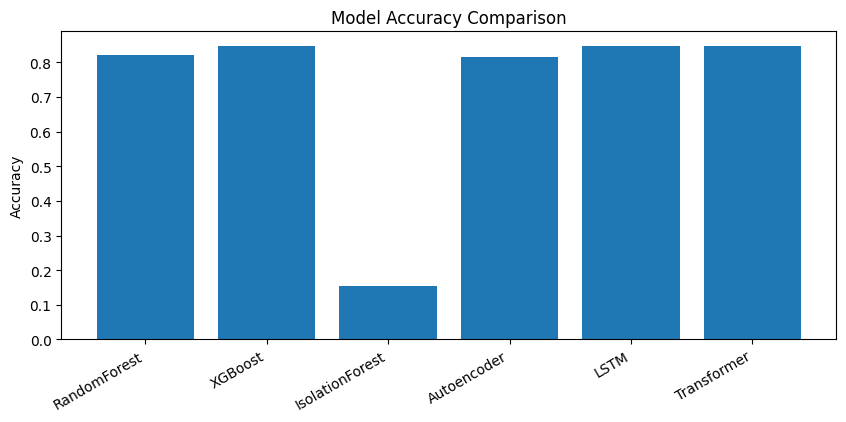

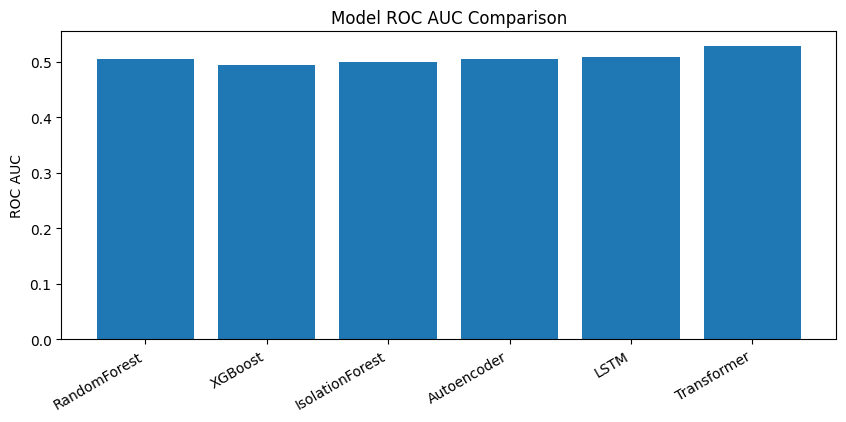

In [ ]:
# --- Final Cell: Evaluate saved models, compare & auto-pick best ---
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

results = []

# --- Random Forest ---
rf_model = joblib.load("models/rf_model.joblib")
rf_preds = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:,1]
results.append({"model": "RandomForest",
                "accuracy": accuracy_score(y_test, rf_preds),
                "roc_auc": roc_auc_score(y_test, rf_proba)})

# --- XGBoost ---
xgb_model = joblib.load("models/xgb_model.joblib")
xgb_preds = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:,1]
results.append({"model": "XGBoost",
                "accuracy": accuracy_score(y_test, xgb_preds),
                "roc_auc": roc_auc_score(y_test, xgb_proba)})

# --- Isolation Forest ---
iso_model = joblib.load("models/iso_model.joblib")
iso_preds = iso_model.predict(X_test)
iso_preds = [1 if p == -1 else 0 for p in iso_preds]  # convert {-1,1} to {0,1}
results.append({"model": "IsolationForest",
                "accuracy": accuracy_score(y_test, iso_preds),
                "roc_auc": roc_auc_score(y_test, iso_preds)})

# --- Autoencoder ---
ae_model = tf.keras.models.load_model("models/ae_model.keras")
recon = ae_model.predict(X_test_s)
mse = np.mean(np.power(X_test_s - recon, 2), axis=1)
ae_preds = (mse > np.percentile(mse, 95)).astype(int)
results.append({"model": "Autoencoder",
                "accuracy": accuracy_score(y_test, ae_preds),
                "roc_auc": roc_auc_score(y_test, ae_preds)})

# --- LSTM ---
lstm_model = tf.keras.models.load_model("models/lstm_model.keras")
lstm_proba = lstm_model.predict(X_seq_test_s).ravel()
lstm_preds = (lstm_proba > 0.5).astype(int)
results.append({"model": "LSTM",
                "accuracy": accuracy_score(y_seq_test, lstm_preds),
                "roc_auc": roc_auc_score(y_seq_test, lstm_proba)})

# --- Transformer ---
trans_model = tf.keras.models.load_model("models/transformer_model.keras")
trans_proba = trans_model.predict(X_seq_test_s).ravel()
trans_preds = (trans_proba > 0.5).astype(int)
results.append({"model": "Transformer",
                "accuracy": accuracy_score(y_seq_test, trans_preds),
                "roc_auc": roc_auc_score(y_seq_test, trans_proba)})

# --- Save & Display ---
results_df = pd.DataFrame(results)
results_path = "models/model_comparison_results.csv"
results_df.to_csv(results_path, index=False)
print(results_df)

# --- Plot Accuracy ---
plt.figure(figsize=(10,4))
plt.bar(results_df['model'], results_df['accuracy'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=30, ha='right')
plt.show()

# --- Plot ROC AUC ---
plt.figure(figsize=(10,4))
plt.bar(results_df['model'], results_df['roc_auc'])
plt.title('Model ROC AUC Comparison')
plt.ylabel('ROC AUC')
plt.xticks(rotation=30, ha='right')
plt.show()